In [81]:
import numpy as np
import rocketcea
import matplotlib.pyplot as plt
import scipy as sp
import plotly.express as px
import pandas as pd

In [82]:
# Define Inputs

#Engine Core Properties
A = 0.005771714879 #Chamber Area [m^2]
P_c= 1241056.31 #Chamber Pressure [Pa] (Adjusted)
A_t = 0.0013738904175253767 #Throat Area [m^2] (Adjusted)

g = 9.81 #Gravitational Acceleration [m/s^2]
R = 8.314 #Universal Gas Constant [J/mol*K]
pi = 3.14159265359

#Chamber Gas/Geometric Properties
G_c = 1.264336443557803 #Chamber Gas Specific Heat Ratio (Adjusted)
T_c = 2259.85 #Chamber Gas Temperature [K] (Adjusted)
M_c = 0.016968051764274335 #Chamber Gas Molecular Weight [kg/mol] (Adjusted)
Cp_c = 2390.733138677419 #Chamber Gas Specific Heat Capacity [J/kg*K] (Adjusted)
mu_c = 0.000071035 #Chamber Gas Viscosity [Pa*s] (Adjusted)
k_c = 0.31235 #Chamber Gas Thermal Conductivity [W/m*K] (Adjusted)
Pr_c = (Cp_c * mu_c)/(k_c) #Chamber Gas Prandtl Number
R_bar_c = R/M_c #Chamber Gas Specific Gas Constant [J/kg*K]

cstar = ((R_bar_c*T_c/G_c) * ((G_c+1)/2)**((G_c+1)/(G_c-1)))**(0.5) #Characteristic Velocity [m/s]
D_t = 2 * (A_t/pi)**(0.5) #Throat Diameter [m]
r_u = 0.00635 #Throat Radius of Curvature [m]

In [83]:
#Function Definitions

def Bartz_Iterator(T_c, T_p, Ma, A, h_p, k_w, t_w):
    T_hw = 500 #Hot Wall Temperature Initial Guess [K]
    T_res = 1
    alpha = 0.3
    count = 0

    while T_res > 10e-6:
        #Update T_hw_old
        T_hw_old = T_hw

        #Bartz Calculation    
        r = Pr_c**0.33 #Recovery Factor
        T_aw = T_c * (((1+(r*(G_c-1)/2)*Ma**2))/((1+((G_c-1)/2)*Ma**2))) #Local Adiabatic Wall Temperature [K]
        s = 1/((((0.5*T_hw/T_c)*(1+((G_c-1)/2)*Ma**2)+0.5)**0.68)*(1+((G_c-1)/2)*Ma**2)**0.12) #Boundary Layer Correction Factor
        h_g = ((0.026/(D_t**0.2))*((Cp_c*mu_c**0.2)/(Pr_c**0.6))*(P_c/cstar)**0.8 * ((D_t/r_u)**0.1))*((A_t/A)**0.9)*s #Bartz Heat Transfer Coefficient [W/m^2*K]
        
        #Obtain new T_hw from Bartz
        q = h_g*(T_aw - T_hw)
        T_cw = (q/h_p) + T_p
        T_hw = q*t_w/k_w + T_cw

        #Under Relaxation
        T_hw = (1-alpha)*T_hw_old + alpha*T_hw
        T_res = abs(T_hw-T_hw_old)

        #count = count + 1
        #print(f"Count: {count}")
    return(T_hw, h_g, q, T_aw)

def Engine_Contour(L, x_c, x_t, x_e, D_c, D_t, D_e, n):
    #Initialize Lists
    x_list = np.linspace(0, L, n)
    D_list = []
    A_list = []

    for x in x_list:
        if x < x_c:
            D_list.append(D_c)
            A_list.append(pi*(D_c/2)**2)
        elif x >= x_c and x < x_t: 
            D = ((D_t - D_c)/(x_t - x_c))*(x - x_c) + D_c
            A = pi*(D/2)**2
            D_list.append(D)
            A_list.append(A)
        elif x >= x_t:
            D = ((D_e - D_t)/(x_e - x_t))*(x - x_t) + D_t
            A = pi*(D/2)**2
            D_list.append(D)
            A_list.append(A)

    r_list1 = [0.5 * D for D in D_list]
    r_list2 = [-0.5 * D for D in D_list]

    fig, ax = plt.subplots()
    ax.plot(x_list, r_list1, 'k-')
    ax.plot(x_list, r_list2, 'k-')
    ax.axis('equal')

    return(x_list, A_list)

def Regen(D_ch, L_ch, n, mdot_p, Cp_p, rho_p, k_p, T_p0):

    #Channel Parameters
    A_ch = pi*(D_ch/2)**2
    P_ch = pi*D_ch
    v_p = mdot_p/(rho_p*A_ch)

    #Initial Conditions
    T_p = T_p0
    mu_p = 0.0015398*np.exp(-6.91098 + 9.78853*(293.15/T_p) - 2.87189*(293.15/T_p)**2)
    Re = rho_p*v_p*D_ch/mu_p
    Pr = Cp_p*mu_p/k_p
    Nu = 0.023*(Re**(4/5))*(Pr**0.4)
    h_p = Nu*k_p/D_ch
    T_hw, h_g, q, T_aw = Bartz_Iterator(T_c = T_c, T_p = T_p, Ma = 0, A = A, h_p = h_p, k_w = 160, t_w = 0.00381) #hard coded values here, fix later
    dx = L_ch/n
    x_list, A_list = Engine_Contour(L = L_ch, x_c = 0.106230, x_t = 0.132530, x_e = 0.197256, D_c = 0.085725, D_t = D_t, D_e = 0.0639501753075, n = n) #hard coded values here, fix later
    x_index = 0

    #Initialize Lists for Plotting Later
    T_p_arr = []
    q_arr = []
    T_hw_arr = []
    h_g_arr = []

    #Propellant Heating
    for x in x_list:
        q_res = 1

        #Adjust dx for Path Length
        if x < 0.106230:
            ds = dx
        elif x >= 0.106230 and x <= 0.132530:
            ds = dx/np.cos(1.1369529591)
        elif x > 0.132530:
            ds = dx/np.cos(0.469083409914)
        
        #Determine Local Area, Mach Number, and Combustion Gas Properties
        A_g = A_list[x_index]
        def f(Ma):
            return((1/Ma**2)*((2/(G_c+1))*(1 + ((G_c-1)*Ma**2)/2))**((G_c+1)/(G_c-1)) - A_g/A_t)
        if x < 0.106230:
            Ma = 0
        elif x >= 0.106230 and x <= 0.132530:
            Ma = sp.optimize.brentq(f, 0.001, 1)
        elif x > 0.132530:
            Ma = sp.optimize.brentq(f, 1, 100)
        
        P = P_c * (1+((G_c-1)/2)*(Ma**2))**(-G_c/(G_c-1))
        #Set previous node's values
        T_p_prev = T_p
        q_prev = q

        # For every x position, run Bartz Loop and Heating Loop
        while q_res > 10e-6:
            
            #Update old values
            T_p_old = T_p
            q_old = q

            #Calculate Temperature Increment
            dT = q*P_ch*ds/(mdot_p*Cp_p)
            T_p = T_p_prev + dT

            #Establish New Material Properties
            T_pavg = (T_p_old + T_p)/2
            mu_p = 0.0015398*np.exp(-6.91098 + 9.78853*(293.15/T_pavg) - 2.87189*(293.15/T_pavg)**2)
            Re = rho_p*v_p*D_ch/mu_p
            Pr = Cp_p*mu_p/k_p
            Nu = 0.023*(Re**(4/5))*(Pr**0.4)
            h_p = Nu*k_p/D_ch

            T_hw, h_g, q, T_aw = Bartz_Iterator(T_c = T_c, T_p = T_p, Ma = Ma, A = A_g, h_p = h_p, k_w = 160, t_w = 0.00381) #hard coded values here, fix later

            q_res = abs(q-q_old)
        
        T_p_arr.append(T_p)
        q_arr.append(q)
        T_hw_arr.append(T_hw)
        h_g_arr.append(h_g)

        x_index = x_index + 1
    
    #Plottin
    
    #MatPlotLib
    #fig, ax = plt.subplots()
    #ax.plot(x_list, T_hw_arr)

    #Plotly
    df = pd.DataFrame(dict(x = x_list, T = T_hw_arr))
    fig = px.line(df, x = "x", y = "T", width = 600, height = 600)
    fig.update_layout(
        title=dict(
            text="Hot Wall Temperature vs Distance from Injector Face"
        ),
        xaxis=dict(
            title=dict(
                text="Distance from Injector Face (m)"
            )
        ),
        yaxis=dict(
            title=dict(
                text="Temperature (K)"
            )
        ),
)
    
    fig.show()


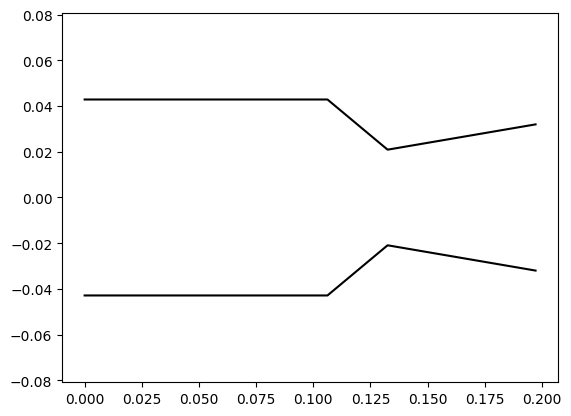

In [84]:
#Test Runs

#Bartz_Iterator(T_c = T_c, T_p = 330, Ma = 0, A = A, h_p = 17435.70437, k_w = 160, t_w = 0.00381)

#Engine_Contour(L = 0.197256, x_c = 0.106230, x_t = 0.132530, x_e = 0.197256, D_c = 0.085725, D_t = 0.028956, D_e = 0.061760, n = 1000)

Regen(D_ch = 0.002763953196, L_ch = 0.197256, n = 1000, mdot_p = 0.1322253981, Cp_p = 2010, rho_p = 820, k_p = 0.125, T_p0 = 330)